In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [2]:
def parse_labels(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_label = int(parts[0])
            x = float(parts[1])
            y = float(parts[2])
            x_width = float(parts[3])
            y_width = float(parts[4])
            labels.append((class_label, x, y, x_width, y_width))
    return np.array(labels)

def plot_bounding_boxes(image_path, label_path):
    # Load the image
    image = Image.open(image_path)

    # Load COCO format labels
    coco_labels = parse_labels(label_path)

    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Add bounding boxes to the image
    for annotation in coco_labels:
        bbox = annotation
        # COCO format: [x, y, width, height]
        class_, x, y, width, height = bbox
        x, y, width, height = x*image.width, y*image.height, width*image.width, height*image.height
        rect = patches.Rectangle((x-width, y-height), width*2, height*2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Display the image with bounding boxes
    plt.show()

# Example usage
# image_path = 'smallsetImage/Kategori4Sag_11773_RCC.png'
# label_path = 'smallsetLabel/Kategori4Sag_11773_RCC.txt'  # Assuming the label file is in JSON format with COCO annotations
# plot_bounding_boxes(image_path, label_path)

In [3]:
class MammogramDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, emptytransform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.emptytransform=emptytransform
        self.count=0

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            label = self.labels[idx]
            # print(label)
            cord=[]
            if self.transform and len(label)>0:
                augmented = self.transform(image=image, bboxes=label[:,1:], class_labels=[0]*len(label))
                image = augmented['image']
                label=augmented["class_labels"]
                cord=augmented["bboxes"]
                    # cord = clip_bboxes(cord)
            else:
                augmented = self.emptytransform(image=image)
                image = augmented['image']
                label=[]
                cord=[]
            return image, label, cord
        except:
            print(f"something went wrong while getting item. Ocurrance {self.count}")
            self.count+=1
            return [], [], []

            

take_directory_i="prodData/train/images/"
take_directory_l="prodData/train/labels/"

image_paths=[take_directory_i+dir for dir in os.listdir(take_directory_i)]
labels=[np.array(parse_labels(take_directory_l+file)) for file in os.listdir(take_directory_l)]
rem=0
image_paths=image_paths[rem:]
labels=labels[rem:]


transform = A.Compose([
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.3),
    A.BBoxSafeRandomCrop(p=0.6),
    ToTensorV2(),
],bbox_params=A.BboxParams(format="yolo",label_fields=["class_labels"],min_area=128))

emptyTransform = A.Compose([
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.3),
    ToTensorV2(),
])



dataset = MammogramDataset(image_paths, labels, transform=transform,emptytransform=emptyTransform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [4]:
# Directory to save the PNG files
save_dir = 'prodAugmented/train/images'
label_dir="prodAugmented/train/labels/"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)


names=os.listdir(take_directory_i)[rem:]

errorCount=0

for i, (image, label, cord) in enumerate(dataloader):
    # Convert the tensor to a NumPy array
    if len(image)<=0:
        errorCount+=1
        print(f"came back as empty {errorCount}")
        continue
    image = image.squeeze().numpy()  # Remove batch dimension and convert to numpy
    image = (image).astype(np.uint8)  # Convert from [0,1] to [0,255] range

    # Convert the NumPy array to a PIL image
    pil_image = Image.fromarray(image)

    # Save the image
    name=names[i][:-4]
    image_filename = f'{name}_aug.png'
    image_save_path = os.path.join(save_dir, image_filename)
    with open(label_dir+image_filename[:-4]+".txt","w") as file:
        for coordinate in cord:
            x, y, width, height=coordinate
            text_label=f"0 {x.item()} {y.item()} {width.item()} {height.item()}\n"
            file.write(text_label)

    pil_image.save(image_save_path)
    print(f'Saved {image_save_path} {i}')


print(f"errors {errorCount}")

Saved prodAugmented/train/images\Kategori1_10001_RCC_aug.png 0
Saved prodAugmented/train/images\Kategori1_10001_RMLO_aug.png 1
Saved prodAugmented/train/images\Kategori1_10002_LCC_aug.png 2
Saved prodAugmented/train/images\Kategori1_10002_LMLO_aug.png 3
Saved prodAugmented/train/images\Kategori1_10004_LCC_aug.png 4
Saved prodAugmented/train/images\Kategori1_10004_LMLO_aug.png 5
Saved prodAugmented/train/images\Kategori1_10008_RCC_aug.png 6
Saved prodAugmented/train/images\Kategori1_10008_RMLO_aug.png 7
Saved prodAugmented/train/images\Kategori1_10009_LCC_aug.png 8
Saved prodAugmented/train/images\Kategori1_10009_LMLO_aug.png 9
Saved prodAugmented/train/images\Kategori1_10010_RCC_aug.png 10
Saved prodAugmented/train/images\Kategori1_10010_RMLO_aug.png 11
Saved prodAugmented/train/images\Kategori1_10012_RCC_aug.png 12
Saved prodAugmented/train/images\Kategori1_10012_RMLO_aug.png 13
Saved prodAugmented/train/images\Kategori1_10014_LCC_aug.png 14
Saved prodAugmented/train/images\Kategori1_

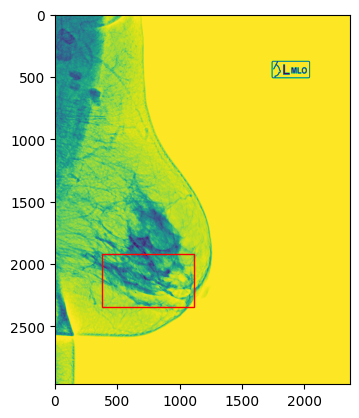

In [9]:
image_path = 'data/train/images/Kategori4Sol_11963_LMLO.png'
label_path = 'data/train/labels/Kategori4Sol_11963_LMLO.txt'  # Assuming the label file is in JSON format with COCO annotations
plot_bounding_boxes(image_path, label_path)

In [10]:
files=["augmentated/val/labels","augmentated/train/labels"]

def change_first_character_to_zero(directory):
    # Iterate over all files in the given directory
    for filename in os.listdir(directory):
        # Check if the file is a .txt file
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            
            # Read the file contents
            with open(file_path, 'r') as file:
                content = file.read()
            
            # If the file is not empty, change the first character to '0'
            if content:
                splits=content.split("\n")
                sum=""
                for s in splits[:-1]:
                    sum+="0"+s[1:]+"\n"
                # new_content = '0' + content[1:]
                
                # Write the new content back to the file
                with open(file_path, 'w') as file:
                    file.write(sum)

In [11]:
for dir in files:
    change_first_character_to_zero(dir)